`Last update at 2021-03-16`

# Background

## Rounds to test
```
Round 1: 60 MAGs; 39 MS/MS-BGC links (1 correct link)
Round 2: 279 genomes/MAGs; 1 MS/MS-BGC links (0 correct link)
Round 3: 279 genomes/MAGs and 589 metagenomes; 16 MS/MS-BGC links (8 correct links)
```

## Outline

```
    3) Creating BGC fingerprints and running KNN:
    3.1) Processing NPLinker ground truth data and loading ENA_dict;
    3.2) Running BiG-SCAPE in a external server; (estimated runtime of 3h)
    3.3) Concatenating BiG-SCAPE results;
    3.4) Processing BiG-SCAPE data;
    3.5) Renaming BGCs in dataframe and dictionary;
    3.6) Creating affinity dataframe;
    3.7) Filtering affinity dataframe to create traning and testing dataframes;
    3.8) Processing KNN;
    3.9) Running cross-validation;
    3.10) Plotting fingerprints.
    
```

In [1]:
import pandas as pd
import time
import glob
import numpy as np
import csv
import subprocess
import glob
import os
import re
import networkx
from networkx.algorithms.components.connected import connected_components
from collections import defaultdict
import matplotlib.pyplot as plt
from Bio import SeqIO
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
import pickle
from sklearn.model_selection import cross_val_score
from pyteomics import mgf, auxiliary

# 3. Creating BGC fingerprints and running KNN

## 3.1. Loading ENA_dict

In [2]:
ena_df = pd.read_csv('./temp_files/ena_dict-round3-210315.csv',sep=',',names=['ERR_code','ERXS_code'])

ena_dict = dict(zip(ena_df['ERXS_code'],ena_df['ERR_code']))

## 3.2. Running BiG-SCAPE in a external server

```
python /home/gerwick-lab/Desktop/bigscape/BiG-SCAPE/bigscape.py \
-i /home/gerwick-lab/Desktop/bigscape/popd_antiSMASH/ \
-o /home/gerwick-lab/Desktop/bigscape/bigscape_outputs_210124/ \
-c 12 --include_singletons --pfam_dir /home/gerwick-lab/Desktop/bigscape/
```

## 3.3. Concatenating BiG-SCAPE results

In [3]:
# %%bash

# cd ./bigscape_outputs_210124/

# rm ./bigscape_all_c030.txt
# find ./network_files/2021-01-24_15-45-51_hybrids_glocal/ -type f -name *_c0.30.network | cat > ./network_files.txt
# while read line; do cat $line >> ./pre_bigscape_all_c030.txt; done < ./network_files.txt
# awk '/Clustername/&&c++>0 {next} 1' ./pre_bigscape_all_c030.txt >> ./bigscape_all_c030.txt

For stats on the annotated metagenomes, see notebook 4 - GCF metadata

## 3.4. Processing BiG-SCAPE data

In [4]:
def get_bigscape_df(input_file):
    bigscape_df = pd.read_csv(input_file,sep='\t')
    bigscape_df.rename(columns=lambda x: re.sub(" ","_",x), inplace=True)
    bigscape_df = bigscape_df[bigscape_df.Clustername_1 != bigscape_df.Clustername_2]
    bigscape_df.reset_index(inplace=True,drop=True)
    return bigscape_df

def get_neighbors(target,dataframe,column1,column2):
    subset1 = dataframe[(dataframe[column1]==target)]
    subcat = subset1.append(dataframe[(dataframe[column2]==target)])
    temp_list = []
    for index,row in subcat.iterrows():
        temp_list.append(subcat[column1][index])
        temp_list.append(subcat[column2][index])
    temp_list = list(np.unique(temp_list))
    return temp_list

def to_edges(l):
    it = iter(l)
    last = next(it)
    for current in it:
        yield last, current
        last = current

def to_graph(l):
    G = networkx.Graph()
    for part in l:
        G.add_nodes_from(part)
        G.add_edges_from(to_edges(part))
    return G

def get_family_dict(components_list,dataframe,dictionary,column1,column2,column3):
    count = 0
    for family in list(components_list):
        count += 1
        for fam_member in family:
            dictionary['GCF%s'%count].append(fam_member)
    return dictionary

def main_get_families(input_file):
    bigscape_df = get_bigscape_df(input_file)
    targets_list = np.unique([bigscape_df.Clustername_1,bigscape_df.Clustername_2])
    neighbors_list = []
    for target in targets_list:
        neighbors_list.append(get_neighbors(target,bigscape_df,'Clustername_1','Clustername_2'))
    G = to_graph(neighbors_list)
    C = connected_components(G)
    gcf_dict = defaultdict(list)
    gcf_dict = get_family_dict(C,bigscape_df,gcf_dict,'Clustername_1','Clustername_2','Raw_distance')
    return bigscape_df,gcf_dict

In [5]:
input_bigscape_net = "/Users/tiagoferreiraleao/Dropbox/tiago-NAS/NPOmix/bigscape_outputs_210124_round3/bigscape_all_c030.txt"

bigscape_df,bigscape_dict = main_get_families(input_bigscape_net)

# to convert from distance to similarity:
bigscape_df["Raw_distance"] = 1-bigscape_df["Raw_distance"]

bigscape_df[:5]

,Clustername_1,Clustername_2,Raw_distance,Squared_similarity,Jaccard_index,DSS_index,Adjacency_index,raw_DSS_non-anchor,raw_DSS_anchor,Non-anchor_domains,Anchor_domains,Combined_group,Shared_group
0,GL383688.1.region001,GL383923.1.region001,0.977518,0.955542,1.000000,0.977518,1.0,0.014224,0.038998,24,3,NRPS - NRPS,NRPS
1,c00528_NODE_52...region001,c00951_NODE_95...region001,0.906949,0.822557,1.000000,0.906949,1.0,0.146222,0.000000,7,1,NRPS-like - NRPS-like,NRPS-like
2,c05228_NODE_52...region001,c05977_NODE_59...region001,0.701125,0.491577,0.666667,0.701125,0.5,0.500000,0.198312,2,1,NRPS-like - NRPS-like,NRPS-like
3,c00702_NODE_70...region001,c01700_NODE_17...region001,0.705753,0.498088,0.250000,0.705753,0.0,1.000000,0.117808,1,1,NRPS-like - NRPS-like,NRPS-like
4,c01177_NODE_11...region001,c01186_NODE_11...region001,0.972527,0.945810,0.500000,0.972527,0.4,0.000000,0.041209,2,1,NRPS-like - NRPS-like,NRPS-like


In [6]:
len(bigscape_dict)

458

## 3.5. Renaming BGCs in dataframe and dictionary

In [7]:
def parse_gbk_list(folder_list):
    gbk_list,new_name_list = [],[]
    for antismash_folder in folder_list:
        for root, dirs, files in os.walk(antismash_folder):
            count = 1
            for file in sorted(files):
                if file.endswith(".gbk"):
                    if 'region' in file and '._' not in file:
                        if 'BGC' in file:
                            new_name = file.rstrip('.gbk')
                            new_name_list.append(new_name)
                            gbk_list.append(file.rstrip('.gbk'))
                        else:
                            strain_name = os.path.basename(os.path.normpath(root)).split('.')[0]
                            gbk_list.append(file.rstrip('.gbk'))
                            new_name = strain_name + '.region' + "{0:0=3d}".format(count)
                            count += 1
                            new_name_list.append(new_name)
    return gbk_list,new_name_list

folder_list = ["/Volumes/TFL190831/ming_output/antismash/"]

gbk_list,new_name_list = parse_gbk_list(folder_list)

len(gbk_list),len(new_name_list)

(13848, 13848)

In [8]:
name_dict = dict(zip(gbk_list, new_name_list))
new_col1, new_col2 = [],[]

for i,r in bigscape_df.iterrows():
    if 'BGC' in bigscape_df['Clustername_1'].loc[i]:
        new_col1.append(bigscape_df['Clustername_1'].loc[i])
    else:
        new_col1.append(name_dict[bigscape_df['Clustername_1'].loc[i]])
    if 'BGC' in bigscape_df['Clustername_2'].loc[i]:
        new_col2.append(bigscape_df['Clustername_2'].loc[i])
    else:
        new_col2.append(name_dict[bigscape_df['Clustername_2'].loc[i]])
    
bigscape_df['Clustername_1'] = new_col1
bigscape_df['Clustername_2'] = new_col2

bigscape_df[:5]

,Clustername_1,Clustername_2,Raw_distance,Squared_similarity,Jaccard_index,DSS_index,Adjacency_index,raw_DSS_non-anchor,raw_DSS_anchor,Non-anchor_domains,Anchor_domains,Combined_group,Shared_group
0,GCA_000144525.region001,GCA_000144855.region001,0.977518,0.955542,1.000000,0.977518,1.0,0.014224,0.038998,24,3,NRPS - NRPS,NRPS
1,ERR2239627_contigs.region001,ERR2239795_contigs.region003,0.906949,0.822557,1.000000,0.906949,1.0,0.146222,0.000000,7,1,NRPS-like - NRPS-like,NRPS-like
2,ERR3941375_contigs.region009,ERR3941223_contigs.region010,0.701125,0.491577,0.666667,0.701125,0.5,0.500000,0.198312,2,1,NRPS-like - NRPS-like,NRPS-like
3,ERR2239604_contigs.region004,ERR3941249_contigs.region003,0.705753,0.498088,0.250000,0.705753,0.0,1.000000,0.117808,1,1,NRPS-like - NRPS-like,NRPS-like
4,ERR2239564_contigs.region008,ERR3946830_contigs.region007,0.972527,0.945810,0.500000,0.972527,0.4,0.000000,0.041209,2,1,NRPS-like - NRPS-like,NRPS-like


In [13]:
bigscape_dict2 = defaultdict(list)

for key in bigscape_dict:
    for value in bigscape_dict[key]:
        if 'BGC' in value:
            bigscape_dict2[key].append(value)
        else:
            if 'ERR' in name_dict[value]:
                new_ERR_name = name_dict[value].split('_')[0] + '.' + name_dict[value].split('.')[1]
                bigscape_dict2[key].append(new_ERR_name)
            else:
                bigscape_dict2[key].append(name_dict[value])
        
len(bigscape_dict2)

458

In [14]:
bigscape_dict2

defaultdict(list,
            {'GCF1': ['GCA_000737335.region031',
              'GCA_000170895.region002',
              'GCA_002994615.region022',
              'GCA_002994635.region018'],
             'GCF2': ['GCA_000156695.region029',
              'GCA_000702365.region011',
              'GCA_000156695.region001',
              'GCA_000377965.region033'],
             'GCF3': ['BGC0000336.1', 'GCA_000156695.region002'],
             'GCF4': ['GCA_003610995.region006',
              'GCA_000702365.region025',
              'GCA_000377965.region032',
              'GCA_000156695.region004'],
             'GCF5': ['GCA_000156695.region005', 'BGC0000431.1'],
             'GCF6': ['GCA_000527195.region012',
              '2515154206.region013',
              '2767802005.region032',
              'GCA_000203835.region009',
              'GCA_000377105.region009',
              'GCA_000702365.region001',
              'GCA_002941025.region024',
              'GCA_000365385.region022',
 

## 3.6. Creating affinity dataframe

In [15]:
def get_pre_training_df(bigscape_df,bigscape_dict,strain_list,bigscape_bgcs):
    training_df = pd.DataFrame(columns=strain_list, index=range(0,len(bigscape_bgcs)))
    index_row = 0
    row_names = []
    for gcf in bigscape_dict:
        for cluster in bigscape_dict[gcf]:
            row_names.append(cluster)
            temp_dict = {}
            self = cluster.split(".")[0]
            temp_dict[self] = [1]
            temp_df = bigscape_df[bigscape_df.Clustername_1.str.contains(cluster) | 
                                  bigscape_df.Clustername_2.str.contains(cluster)]
            for i,r in temp_df.iterrows():
                if temp_df.Clustername_1.loc[i] == cluster:
                    target = temp_df.Clustername_2.loc[i]
                    target = str(target).split(".")[0]
                    if target not in temp_dict:
                        temp_dict[target] = [temp_df.Raw_distance.loc[i]]
                    else:
                        temp_dict[target] = temp_dict[target]+[temp_df.Raw_distance.loc[i]]
                else:
                    target = temp_df.Clustername_1.loc[i]
                    target = str(target).split(".")[0]
                    if target not in temp_dict.keys():
                        temp_dict[target] = [temp_df.Raw_distance.loc[i]]
                    else:
                        temp_dict[target] = temp_dict[target]+[temp_df.Raw_distance.loc[i]]
            for key in temp_dict:
                if len(temp_dict[key]) > 1:
                    new_value = max(temp_dict[key])
                    temp_dict[key] = new_value
                else:
                    temp_dict[key] = temp_dict[key][0]
            temp_dict["label"] = gcf
            training_df.loc[index_row] = pd.Series(temp_dict)
            index_row += 1
    training_df.fillna(0,inplace=True)
    return training_df,row_names

In [16]:
bgcs_list = list(np.unique([bigscape_df['Clustername_1']]+[bigscape_df['Clustername_2']]))
strain_list = []

for item in bgcs_list:
    if "BGC" not in item:
        strain_list.append(item.split(".")[0])
strain_list = list(np.unique(strain_list))
strain_list.append("label")
    
affinity_df,affinity_bgcs = get_pre_training_df(bigscape_df,bigscape_dict2,strain_list,bgcs_list)

affinity_df.shape

(2869, 842)

In [17]:
!ls -d /Volumes/TFL190831/ming_output/antismash/*/ | wc -l

    1766


In [18]:
!ls -d /Volumes/TFL190831/ming_output/antismash/ER*/ | wc -l

    1034


In [19]:
affinity_df[:5]

,2515154206,2528311045,2537561939,2547132079,2600255118,2724679019,2767802005,651717009,ERR2239098_contigs,ERR2239119_contigs,...,GCA_009711975,GCA_009711985,GCA_009712035,GCA_009712065,GCA_009712075,GCA_009712085,GCA_009712125,GCA_011290345,GCA_011751035,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF2


In [20]:
new_affinity_names = []

for item in list(affinity_df.columns):
    if '_contigs' in item:
        new_affinity_names.append(item.split('_')[0])
    else:
        new_affinity_names.append(item)
        
affinity_df.columns = new_affinity_names

In [21]:
affinity_df[:5]

,2515154206,2528311045,2537561939,2547132079,2600255118,2724679019,2767802005,651717009,ERR2239098,ERR2239119,...,GCA_009711975,GCA_009711985,GCA_009712035,GCA_009712065,GCA_009712075,GCA_009712085,GCA_009712125,GCA_011290345,GCA_011751035,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF2


In [18]:
# affinity_df.to_csv("./outputs/affinity_df-round3-TFL210316.txt")
# pickle.dump( affinity_bgcs, open( "./outputs/affinity_bgcs-round3-TFL210316.txt", "wb" ) )

## 3.X Calculating beta-diversity

In [22]:
cluster_list = []
strains = []

for item in bigscape_dict2.values():
    cluster_list = cluster_list + item

for item in cluster_list:
    if 'BGC' in item[:3]:
        strains.append('MIBiG')
    else:
        strains.append(item.split('.')[0])

col_names = list(np.unique(strains))

family_rows = []
indexes = []

for key,value in bigscape_dict2.items():
    indexes.append(key)
    row = []
    for strain in col_names:
        if strain == "MIBiG":
            find_substring_in_list = [s for s in value if "BGC" in s]
            sublist = filter(lambda x: "BGC" in x, value)
            sublist = list(sublist)
        else:
            find_substring_in_list = [s for s in value if strain.lower() in s.lower()] # .lower() for case insensitive
            sublist = filter(lambda x: strain in x, value)
            sublist = list(sublist)
            for item in find_substring_in_list:
                if 'BGC' in item[:3]:
                    find_substring_in_list.remove(item)
                    sublist.remove(item)
        if find_substring_in_list:
            row.append(sublist)
        else:
            row.append(0)
    family_rows.append(row)
    
gcf_patterns = pd.DataFrame(family_rows,columns=col_names,index=indexes)

In [23]:
gcf_patterns[gcf_patterns['ERR3941051'] != 0]

,2515154206,2528311045,2537561939,2547132079,2600255118,2724679019,2767802005,651717009,ERR2239098,ERR2239119,...,GCA_009711975,GCA_009711985,GCA_009712035,GCA_009712065,GCA_009712075,GCA_009712085,GCA_009712125,GCA_011290345,GCA_011751035,MIBiG
GCF29,0,0,0,[2547132079.region001],0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GCF404,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GCF448,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
family_counts = []

for i,r in gcf_patterns.iterrows():
    new_row = []
    for item in r:
        if item == 0:
            new_row.append(0)
        else:
            new_row.append(1)
    family_counts.append(new_row)
    
gcf_binary = pd.DataFrame(family_counts,columns=col_names,index=indexes)

gcf_binary[:5]

,2515154206,2528311045,2537561939,2547132079,2600255118,2724679019,2767802005,651717009,ERR2239098,ERR2239119,...,GCA_009711975,GCA_009711985,GCA_009712035,GCA_009712065,GCA_009712075,GCA_009712085,GCA_009712125,GCA_011290345,GCA_011751035,MIBiG
GCF1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GCF2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GCF3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
GCF4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GCF5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [25]:
from scipy.spatial import distance
from scipy.cluster import hierarchy
import seaborn as sns
from skbio.diversity import beta_diversity
import matplotlib.pyplot as plt
sns.set()
#sns.set_context("talk")
%matplotlib inline

header = list(gcf_binary.columns.values)
# gcf_binary.index.names = ['GCFs']

ids = gcf_binary.columns.astype(str).tolist()
# data = gcf_binary.as_matrix()
data = gcf_binary[col_names].values
data = data.transpose()
data = data.astype(int)

bc_dm = beta_diversity('jaccard', data, ids)
bc_dm_df = bc_dm.to_data_frame()

/Users/tiagoferreiraleao/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1735: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [26]:
sns.set(color_codes=True)

fig = plt.figure()
diversity_scores = {}

for i,r in bc_dm_df.iterrows():
    diversity_scores[i] = np.average(bc_dm_df[i])#,np.std(bc_dm_df[i])
    
diversity_scores

{'2515154206': 0.990899115894326,
 '2528311045': 0.9904665953107417,
 '2537561939': 0.996437054631829,
 '2547132079': 0.949612600384572,
 '2600255118': 0.9982185273159145,
 '2724679019': 0.9880244731418732,
 '2767802005': 0.9886361865325376,
 '651717009': 0.9922423812077796,
 'ERR2239098': 0.8046695321042114,
 'ERR2239119': 0.9632719714964371,
 'ERR2239132': 0.9632719714964371,
 'ERR2239139': 0.8046695321042114,
 'ERR2239166': 0.8046695321042114,
 'ERR2239172': 0.9923085623798215,
 'ERR2239187': 0.9620546318289785,
 'ERR2239189': 0.9620546318289785,
 'ERR2239191': 0.9292444293631942,
 'ERR2239195': 0.9971496437054632,
 'ERR2239196': 0.953452620881362,
 'ERR2239204': 0.9872987595671681,
 'ERR2239205': 0.9292444293631942,
 'ERR2239207': 0.9924946787179566,
 'ERR2239211': 0.9982185273159145,
 'ERR2239213': 0.9985154394299287,
 'ERR2239214': 0.9437177166987143,
 'ERR2239216': 0.982649021603891,
 'ERR2239220': 0.9632719714964371,
 'ERR2239222': 0.8046695321042114,
 'ERR2239223': 0.804669532

<Figure size 432x288 with 0 Axes>

In [30]:
seen = []

for key in diversity_scores:
    if diversity_scores[key] >= 0.997:
        if 'GCA' in key:
            gca_glob = glob.glob('/Volumes/TFL190831/podp_LCMS/%s*'%key)
            if gca_glob:
                for lcms_file in gca_glob:
                    cmd = 'cp %s ~/Downloads/KNN_apporach/round3.8/selected_mxML/'%lcms_file
                    if key not in seen:
                        seen.append(key)
                        print(key)
#                     subprocess.call(cmd,shell=True)

GCA_000012265
GCA_000012445
GCA_000087965
GCA_000145075
GCA_000162455
GCA_000166275
GCA_000170895
GCA_000180455
GCA_000209465
GCA_000238295
GCA_000273725
GCA_000296385
GCA_000316115
GCA_000317125
GCA_000317145
GCA_000317555
GCA_000332195
GCA_000332215
GCA_000338635
GCA_000340725
GCA_000482585
GCA_000506385
GCA_000507825
GCA_000514995
GCA_000517105
GCA_000737335
GCA_001562525
GCA_001625105
GCA_002994615
GCA_002994635
GCA_003324555


## 3.X Separating and re-naming mgf files

In [31]:
glob_ccms = glob.glob('./selected_mgf_round3/*.mgf')
ccms_list = []

for item in glob_ccms:
    ccms_list.append(os.path.basename(item).split('.')[0])

len(ccms_list)

2178

In [32]:
count = 0

with mgf.MGF('/Users/tiagoferreiraleao/Downloads/KNN_apporach/round3.8/mzmine/PoDP_div_genomes-TFL210409.mgf') as reader:
    for spectrum in reader:
        for key in spectrum.keys():
            if key == 'params':
                if spectrum[key]['pepmass'][0] > 500:
                    count += 1
                    individual_spec = []
                    individual_spec.append(spectrum)
                    output_file = '/Users/tiagoferreiraleao/Downloads/KNN_apporach/round3.8/selected_mgf/%s.mgf'%(ccms_list[count])
#                     mgf.write(spectra=individual_spec, header='', output=output_file)

In [33]:
!ls /Users/tiagoferreiraleao/Downloads/KNN_apporach/round3.8/selected_mgf/ | wc -l

     300


## 3.7. Filtering affinity dataframe to create traning and testing dataframes

In [34]:
### first run the notebook 2 to process ispec_mat (by Ricardo Silva)

ispec_mat = pd.read_csv("/Users/tiagoferreiraleao/Dropbox/tiago-NAS/NPOmix/outputs/mass-affinity_df-round3.8-TFL210401.txt",sep="\t")

ispec_mat

,ERS4341365,GCA_000240165,GCA_011290345,GCA_000506385,GCA_000012265,GCA_003324555,GCA_000012445,GCA_001562525,GCA_002899455,GCA_003248315,...,ERS4356314,ERS4356315,ERS4356317,ERS4356319,ERS4356320,ERS4356321,ERS4356322,ERS4356323,ERS4356324,ERS4341364
CCMSLIB00004720895,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.003681,0.000000,0.000000,0.000000,0.000000,0.000000,0.001696,0.000000,0.0
CCMSLIB00000217939,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
CCMSLIB00004720881,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
CCMSLIB00004702361,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
CCMSLIB00000567505,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCMSLIB00005724314,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
CCMSLIB00004681481,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
CCMSLIB00004721623,0.0,0.123055,0.0,0.437479,0.0,0.0,0.725891,0.711771,0.666782,0.640959,...,0.162297,0.241437,0.185758,0.182472,0.175575,0.196460,0.198714,0.000000,0.186469,0.0
CCMSLIB00004721179,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.072798,0.103998,0.086590,0.000000,0.099330,0.122576,0.000000,0.018233,0.107091,0.0


In [35]:
new_cols_ispec = []

for item in ispec_mat.columns:
    if 'ERS' in item or 'ERX' in item:
        new_cols_ispec.append(ena_dict[item])
    else:
        new_cols_ispec.append(item)
        
ispec_mat.columns = new_cols_ispec

ispec_mat

,ERR3941051,GCA_000240165,GCA_011290345,GCA_000506385,GCA_000012265,GCA_003324555,GCA_000012445,GCA_001562525,GCA_002899455,GCA_003248315,...,ERR3958140,ERR3958141,ERR3958143,ERR3958145,ERR3958146,ERR3958147,ERR3958148,ERR3958149,ERR3958150,ERR3941050
CCMSLIB00004720895,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.003681,0.000000,0.000000,0.000000,0.000000,0.000000,0.001696,0.000000,0.0
CCMSLIB00000217939,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
CCMSLIB00004720881,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
CCMSLIB00004702361,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
CCMSLIB00000567505,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCMSLIB00005724314,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
CCMSLIB00004681481,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
CCMSLIB00004721623,0.0,0.123055,0.0,0.437479,0.0,0.0,0.725891,0.711771,0.666782,0.640959,...,0.162297,0.241437,0.185758,0.182472,0.175575,0.196460,0.198714,0.000000,0.186469,0.0
CCMSLIB00004721179,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.072798,0.103998,0.086590,0.000000,0.099330,0.122576,0.000000,0.018233,0.107091,0.0


In [36]:
networked_cols = []

for item in ispec_mat.columns:
    if item in affinity_df.columns:
        networked_cols.append(item)
        
len(networked_cols)

515

In [37]:
specn = os.listdir("/Volumes/TFL190831/podp_LCMS/")

filt_specn = []

for item in specn:
    if '._' not in item:
        filt_specn.append(item.split('.')[0])

filt_specn = list(np.unique(filt_specn))
        
len(filt_specn)

852

In [38]:
training_df = affinity_df[networked_cols]
label_col = affinity_df['label']
training_df = training_df[(training_df.T != 0).any()]

filt_label_col = []
for n,item in enumerate(label_col):
    if n in training_df.index:
        filt_label_col.append(item)


training_df['label'] = filt_label_col
training_df = training_df.sort_index(axis=1)

training_df

,ERR3941051,ERR3941055,ERR3941057,ERR3941059,ERR3941060,ERR3941062,ERR3941063,ERR3941065,ERR3941067,ERR3941069,...,GCA_001625105,GCA_002899455,GCA_002994615,GCA_002994635,GCA_003248315,GCA_003324555,GCA_003610995,GCA_007363395,GCA_011290345,label
0,0,0,0,0,0,0.0,0,0,0,0,...,0.0,0.0,0.000000,0.854972,0.0,0.0,0.0,0.0,0.0,GCF1
1,0,0,0,0,0,0.0,0,0,0,0,...,0.0,0.0,0.744399,0.725292,0.0,0.0,0.0,0.0,0.0,GCF1
2,0,0,0,0,0,0.0,0,0,0,0,...,0.0,0.0,1.000000,0.817521,0.0,0.0,0.0,0.0,0.0,GCF1
3,0,0,0,0,0,0.0,0,0,0,0,...,0.0,0.0,0.817521,1.000000,0.0,0.0,0.0,0.0,0.0,GCF1
4,0,0,0,0,0,0.0,0,0,0,0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,GCF2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1373,0,0,0,0,0,0.0,0,0,0,0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,GCF260
1374,0,0,0,0,0,0.0,0,0,0,0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,GCF261
1375,0,0,0,0,0,0.0,0,0,0,0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,GCF261
1386,0,0,0,0,0,0.0,0,0,0,0,...,0.0,0.0,0.783285,1.000000,0.0,0.0,0.0,0.0,0.0,GCF266


In [39]:
training_df[training_df['ERR3941051'] != 0]

,ERR3941051,ERR3941055,ERR3941057,ERR3941059,ERR3941060,ERR3941062,ERR3941063,ERR3941065,ERR3941067,ERR3941069,...,GCA_001625105,GCA_002899455,GCA_002994615,GCA_002994635,GCA_003248315,GCA_003324555,GCA_003610995,GCA_007363395,GCA_011290345,label


In [40]:
testing_df = ispec_mat[networked_cols]
testing_df = testing_df.sort_index(axis=1) ### comment this line out for random result
testing_df = testing_df[testing_df > 0.7].replace(np.nan,0)
testing_df = testing_df[(testing_df.T != 0).any()]

testing_df

,ERR3941051,ERR3941055,ERR3941057,ERR3941059,ERR3941060,ERR3941062,ERR3941063,ERR3941065,ERR3941067,ERR3941069,...,GCA_001562525,GCA_001625105,GCA_002899455,GCA_002994615,GCA_002994635,GCA_003248315,GCA_003324555,GCA_003610995,GCA_007363395,GCA_011290345
CCMSLIB00004720895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
CCMSLIB00004720881,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
CCMSLIB00000567505,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
CCMSLIB00000205118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
CCMSLIB00004689144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCMSLIB00004713939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
CCMSLIB00004712821,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
CCMSLIB00000567265,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
CCMSLIB00000221137,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.718331,0.0,0.714179,0.0,0.732350,0.0,0.0,0.0,0.0,0.0


In [41]:
ispec_mat.shape,training_df.shape,testing_df.shape

((273, 786), (973, 516), (72, 515))

`Only use the next two cells below for presence/absence comparision`

In [42]:
### only run once

# family_counts = []

# for i,r in training_df.drop('label',axis=1).iterrows():
#     new_row = []
#     for item in r:
#         if item == 0:
#             new_row.append(0)
#         else:
#             new_row.append(1)
#     family_counts.append(new_row)
    
# training_df = pd.DataFrame(family_counts,columns=networked_cols,index=training_df.index)

# training_df['label'] = filt_label_col

# training_df[:5]

In [43]:
### only run once

# family_counts = []

# for i,r in testing_df.iterrows():
#     new_row = []
#     for item in r:
#         if item == 0:
#             new_row.append(0)
#         else:
#             new_row.append(1)
#     family_counts.append(new_row)
    
# testing_df = pd.DataFrame(family_counts,columns=networked_cols,index=testing_df.index)

# testing_df[:5]

In [44]:
# training_df.to_csv('./outputs/training_df-round3-TFL210316.tsv',sep='\t')
# testing_df.to_csv('./outputs/testing_df-round3-TFL210316.tsv',sep='\t')

## 3.8. Processing KNN

In [45]:
X_div = training_df.drop("label", axis=1)
X_div.shape

(973, 515)

In [46]:
y_div = training_df["label"]
y_div.shape

(973,)

In [47]:
nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(X_div,y_div)

distances, indices = nbrs.kneighbors(testing_df)

In [48]:
y_div = y_div.reset_index(drop=True)

neighbors_array = []

for item in indices:
    candidate_list = []
    for i in range(5):
        candidate_list.append(y_div[item[i]])
    neighbors_array.append(candidate_list)

neighbors_array = np.asarray(neighbors_array)
        
neighbors_array

array([['GCF188', 'GCF188', 'GCF131', 'GCF10', 'GCF19'],
       ['GCF188', 'GCF188', 'GCF131', 'GCF10', 'GCF19'],
       ['GCF188', 'GCF188', 'GCF131', 'GCF10', 'GCF19'],
       ['GCF188', 'GCF188', 'GCF131', 'GCF10', 'GCF19'],
       ['GCF188', 'GCF188', 'GCF131', 'GCF10', 'GCF19'],
       ['GCF188', 'GCF188', 'GCF131', 'GCF10', 'GCF19'],
       ['GCF188', 'GCF188', 'GCF131', 'GCF10', 'GCF19'],
       ['GCF188', 'GCF188', 'GCF131', 'GCF10', 'GCF19'],
       ['GCF188', 'GCF188', 'GCF131', 'GCF10', 'GCF19'],
       ['GCF188', 'GCF188', 'GCF131', 'GCF10', 'GCF19'],
       ['GCF188', 'GCF188', 'GCF131', 'GCF10', 'GCF19'],
       ['GCF28', 'GCF28', 'GCF131', 'GCF10', 'GCF19'],
       ['GCF28', 'GCF28', 'GCF131', 'GCF10', 'GCF19'],
       ['GCF28', 'GCF28', 'GCF131', 'GCF10', 'GCF19'],
       ['GCF28', 'GCF28', 'GCF131', 'GCF10', 'GCF19'],
       ['GCF171', 'GCF171', 'GCF131', 'GCF10', 'GCF19'],
       ['GCF193', 'GCF193', 'GCF131', 'GCF10', 'GCF19'],
       ['GCF193', 'GCF193', 'GCF162', '

In [49]:
for i,item in enumerate(testing_df.index):
    print(item,neighbors_array[i])

CCMSLIB00004720895 ['GCF188' 'GCF188' 'GCF131' 'GCF10' 'GCF19']
CCMSLIB00004720881 ['GCF188' 'GCF188' 'GCF131' 'GCF10' 'GCF19']
CCMSLIB00000567505 ['GCF188' 'GCF188' 'GCF131' 'GCF10' 'GCF19']
CCMSLIB00000205118 ['GCF188' 'GCF188' 'GCF131' 'GCF10' 'GCF19']
CCMSLIB00004689144 ['GCF188' 'GCF188' 'GCF131' 'GCF10' 'GCF19']
CCMSLIB00004691045 ['GCF188' 'GCF188' 'GCF131' 'GCF10' 'GCF19']
CCMSLIB00000218175 ['GCF188' 'GCF188' 'GCF131' 'GCF10' 'GCF19']
CCMSLIB00000220213 ['GCF188' 'GCF188' 'GCF131' 'GCF10' 'GCF19']
CCMSLIB00004721619 ['GCF188' 'GCF188' 'GCF131' 'GCF10' 'GCF19']
CCMSLIB00000839190 ['GCF188' 'GCF188' 'GCF131' 'GCF10' 'GCF19']
CCMSLIB00000078771 ['GCF188' 'GCF188' 'GCF131' 'GCF10' 'GCF19']
CCMSLIB00004689030 ['GCF28' 'GCF28' 'GCF131' 'GCF10' 'GCF19']
CCMSLIB00000566960 ['GCF28' 'GCF28' 'GCF131' 'GCF10' 'GCF19']
CCMSLIB00000213626 ['GCF28' 'GCF28' 'GCF131' 'GCF10' 'GCF19']
CCMSLIB00004721180 ['GCF28' 'GCF28' 'GCF131' 'GCF10' 'GCF19']
CCMSLIB00000566784 ['GCF171' 'GCF171' 'GCF131' '

In [50]:
from sklearn.metrics import jaccard_score

def get_binary(fingerprint):
    new_row = []
    for index,item in enumerate(fingerprint):
        if item != 0:
            new_row.append(1)
        else:
            new_row.append(0)
    fingerprint = new_row
    return fingerprint

for i,ccms_id in enumerate(testing_df.index):
    jaccard_scores = []
    for j in range(0,len(neighbors_array)):
        query_bgc = neighbors_array[i][0] #only the top match has to be in the same strain
        bgc_fp = training_df[training_df['label'] == query_bgc].iloc[0]
        bgc_fp = bgc_fp.drop("label")
        ms_fp = testing_df.loc[ccms_id]
        bgc_binary = get_binary(bgc_fp)
        ms_binary = get_binary(ms_fp)
        jaccard_scores.append(jaccard_score(bgc_binary,ms_binary))
    max_jaccard = max(jaccard_scores)
    if max_jaccard > 0.9:
        print(ccms_id,neighbors_array[i],max_jaccard)

CCMSLIB00004720895 ['GCF188' 'GCF188' 'GCF131' 'GCF10' 'GCF19'] 1.0
CCMSLIB00004720881 ['GCF188' 'GCF188' 'GCF131' 'GCF10' 'GCF19'] 1.0
CCMSLIB00000567505 ['GCF188' 'GCF188' 'GCF131' 'GCF10' 'GCF19'] 1.0
CCMSLIB00000205118 ['GCF188' 'GCF188' 'GCF131' 'GCF10' 'GCF19'] 1.0
CCMSLIB00004689144 ['GCF188' 'GCF188' 'GCF131' 'GCF10' 'GCF19'] 1.0
CCMSLIB00004691045 ['GCF188' 'GCF188' 'GCF131' 'GCF10' 'GCF19'] 1.0
CCMSLIB00000218175 ['GCF188' 'GCF188' 'GCF131' 'GCF10' 'GCF19'] 1.0
CCMSLIB00000220213 ['GCF188' 'GCF188' 'GCF131' 'GCF10' 'GCF19'] 1.0
CCMSLIB00004721619 ['GCF188' 'GCF188' 'GCF131' 'GCF10' 'GCF19'] 1.0
CCMSLIB00000839190 ['GCF188' 'GCF188' 'GCF131' 'GCF10' 'GCF19'] 1.0
CCMSLIB00000078771 ['GCF188' 'GCF188' 'GCF131' 'GCF10' 'GCF19'] 1.0
CCMSLIB00004689030 ['GCF28' 'GCF28' 'GCF131' 'GCF10' 'GCF19'] 1.0
CCMSLIB00000566960 ['GCF28' 'GCF28' 'GCF131' 'GCF10' 'GCF19'] 1.0
CCMSLIB00000213626 ['GCF28' 'GCF28' 'GCF131' 'GCF10' 'GCF19'] 1.0
CCMSLIB00004721180 ['GCF28' 'GCF28' 'GCF131' 'GCF10' '

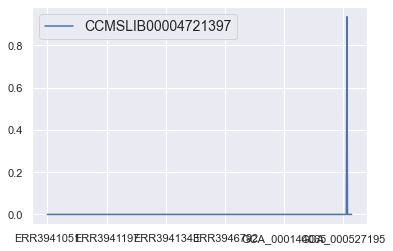

In [51]:
mf_subset1 = testing_df.loc['CCMSLIB00004721397'].T

mf_subset1.plot().legend(loc=2, prop={'size': 14})

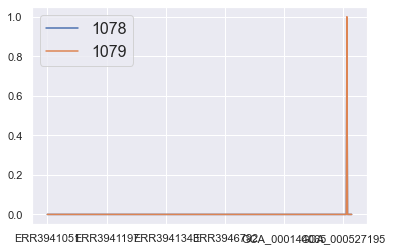

In [52]:
gcf_subset1 = training_df[training_df['label'] == 'GCF171'].T
gcf_subset1 = gcf_subset1.drop('label')

gcf_subset1.plot().legend(loc=2, prop={'size': 16})

In [53]:
bigscape_dict2['GCF171']

['BGC0000632.1', 'GCA_001625105.region031']

----

----

----

In [60]:
intensity_df = pd.read_csv('/Users/tiagoferreiraleao/Downloads/KNN_apporach/round3.8/mzmine/PoDP_div_genomes-TFL210409_quant.csv',sep=',')

intensity_df

,row ID,row m/z,row retention time,GCA_000162455.2.mzXML Peak area,GCA_000145075.3.mzXML Peak area,GCA_000145075.1.mzXML Peak area,GCA_000087965.7.mzXML Peak area,GCA_000087965.6.mzXML Peak area,GCA_000087965.5.mzXML Peak area,GCA_000087965.3.mzXML Peak area,...,GCA_001625105.1.mzXML Peak area,GCA_003324555.1.mzXML Peak area,GCA_003324555.2.mzXML Peak area,GCA_000166275.4.mzML Peak area,GCA_000166275.6.mzML Peak area,GCA_000166275.5.mzML Peak area,GCA_000166275.2.mzML Peak area,GCA_000166275.3.mzML Peak area,GCA_000166275.1.mzML Peak area,Unnamed: 49
0,1,357.278827,5.892738,6.833294e+06,1.008252e+07,7.493353e+06,0.000000,0.000000,0.000000,0.000000,...,169.8950,205.4850,205.4850,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,NaN
1,2,166.086380,1.105981,9.004399e+06,1.445379e+07,9.031438e+06,0.000000,0.000000,0.000000,0.000000,...,1188.7500,579.4100,579.4100,4396.582439,802.029825,2.494025e+06,0.000000,2.250107e+06,2.055002e+06,NaN
2,3,120.080796,1.109642,5.668750e+06,8.866810e+06,6.041906e+06,0.000000,0.000000,0.000000,0.000000,...,866.9135,396.8080,396.8080,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,NaN
3,4,373.273976,4.883595,4.843184e+06,7.024530e+06,5.323045e+06,0.000000,0.000000,0.000000,540.928170,...,148.2720,148.2720,148.2720,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,NaN
4,5,328.139691,1.146751,2.294897e+05,8.028939e+06,8.923005e+04,0.000000,0.000000,0.000000,0.000000,...,181.3510,0.0000,0.0000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3816,7755,442.336044,6.672801,0.000000e+00,0.000000e+00,6.034050e+01,0.000000,0.000000,0.000000,0.000000,...,565.1760,203.8080,203.8080,0.000000,0.000000,5.715876e+06,0.000000,1.774104e+06,1.964919e+06,NaN
3817,7756,357.175921,4.571281,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,384.5425,270.2875,270.2875,0.000000,0.000000,3.614216e+06,0.000000,1.181873e+07,8.344939e+05,NaN
3818,7764,195.992481,2.205563,4.160305e+02,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,350.1150,310.4445,310.4445,0.000000,0.000000,3.679318e+06,0.000000,2.055612e+06,5.144874e+06,NaN
3819,7784,215.138688,1.617985,1.224981e+04,5.329238e+04,2.468758e+04,793.914932,943.276118,1176.968894,1136.538763,...,0.0000,208.6960,208.6960,0.000000,0.000000,5.169568e+05,76514.529133,8.384336e+05,1.412022e+06,NaN


In [77]:
intensity_dict = {}

for i,r in intensity_df.iterrows():
    pep_mass = round(r['row m/z'],4)
    max_intensity = r.max()
    intensity_dict[pep_mass] = max_intensity
    
intensity_dict

{357.2788: 11330221.053500013,
 166.0864: 16672117.847500013,
 120.0808: 11452561.178500008,
 373.274: 7909108.321999992,
 328.1397: 15050898.877500005,
 188.0708: 9922446.100499997,
 355.2636: 4399771.665499995,
 205.0976: 6418381.559499998,
 310.1293: 6529702.778500001,
 843.2668: 211515006.50393325,
 843.2569: 186850886.3770309,
 469.3367: 59955879.74140611,
 607.0442: 93725326.73396872,
 607.0418: 7697028.0766846975,
 602.0493: 5714258.1983281365,
 718.538: 177562811.91682804,
 602.0423: 3329381.491298891,
 718.544: 151062977.9832813,
 718.5434: 23755609.09906262,
 391.2811: 116195367.28296489,
 718.5362: 9069367.929843737,
 718.5368: 260101814.2266875,
 718.5432: 252331122.29472265,
 718.5419: 9237946.85304686,
 602.0454: 3244133.7316162344,
 704.5234: 1014969387.6125313,
 704.529: 1043232292.9219573,
 891.2799: 275357051.79070324,
 891.2887: 259347923.60173452,
 704.5286: 922877000.8842069,
 704.5224: 59527834.80765627,
 704.5261: 53920563.86375002,
 874.1072: 38077665.05792949,


In [151]:
def get_feature(updated_name,name_dict):
    bgc_name = 0
    for key in name_dict.keys():
        if name_dict[key] == updated_name:
            if bgc_name == 0:
                bgc_name = key
                input_handle = open("/Volumes/TFL190831/ming_output/antismash/%s.fasta_output_results/%s.gbk"%(updated_name.split('.')[0],bgc_name),'r')
                for seq_record in SeqIO.parse(input_handle,'genbank'):
                    edge_list,type_list = [],[]
                    for feature in seq_record.features:
                        if feature.type == 'cand_cluster':
                            for qual in feature.qualifiers:
                                if qual == 'contig_edge':
                                    ctg_edge = feature.qualifiers[qual]
                                    edge_list.append(ctg_edge[0])
                                if qual == 'product':
                                    bgc_type = feature.qualifiers[qual]
                                    for item_type in bgc_type:
                                        if item_type not in type_list:
                                            type_list.append(item_type)
                    return edge_list,type_list

def most_frequent(List):
    counter = 0
    num = List[0]     
    for i in List:
        curr_frequency = List.count(i)
        if(curr_frequency> counter):
            counter = curr_frequency
            num = i
    return num
     
def consensus_quals(gcf):
    final_edge_list,final_type_list = [],[]
    for candidate in bigscape_dict2[gcf]:
        if 'BGC' not in candidate and 'ERR' not in candidate:
            ctg_edge,bgc_type = get_feature(candidate,name_dict)
            for edge in ctg_edge:
                final_edge_list.append(edge)
            for class_type in bgc_type:
                final_type_list.append(class_type)
    return most_frequent(final_edge_list),list(np.unique(final_type_list))

consensus_quals('GCF266')

('False', ['ectoine'])

In [156]:
def get_ms2_data(ccms_id):
    with mgf.MGF('/Users/tiagoferreiraleao/Downloads/KNN_apporach/round3.8/selected_mgf/%s.mgf'%ccms_id) as reader:
        for spectrum in reader:
            for key in spectrum.keys():
                if key == 'params':
                    return spectrum[key]['pepmass'][0],spectrum[key]['rtinseconds']

mining_df = pd.DataFrame(columns=('index','m/z','rt','gcf','MIBiG','genomes','intensity','ctg_edge','gcf_type'))
count = 0            
    
for i,ccms_id in enumerate(testing_df.index):
    for gcf in neighbors_array[i]:
        count += 1
        res_list = [i for i in list(bigscape_dict2[gcf]) if 'BGC' in i]
        mz_value,rt_value = get_ms2_data(ccms_id)
        gca_list = [i for i in list(bigscape_dict2[gcf]) if 'GCA' in i]
        edges_final,gcf_type = consensus_quals(gcf)
        if len(res_list) != 0:
            mining_df.loc[count] = i,mz_value,rt_value,gcf,res_list,intensity_dict[mz_value],gca_list,edges_final,gcf_type
        else:
            mining_df.loc[count] = i,mz_value,rt_value,gcf,'None',intensity_dict[mz_value],gca_list,edges_final,gcf_type

In [157]:
mining_df

,index,m/z,rt,gcf,MIBiG,genomes,intensity,ctg_edge,gcf_type
1,0,843.2569,712.534,GCF188,[BGC0001088.1],1.868509e+08,[GCA_000087965.region007],False,"[NRPS, transAT-PKS-like]"
2,0,843.2569,712.534,GCF188,[BGC0001088.1],1.868509e+08,[GCA_000087965.region007],False,"[NRPS, transAT-PKS-like]"
3,0,843.2569,712.534,GCF131,None,1.868509e+08,"[GCA_000515055.region020, GCA_003610995.region...",False,"[betalactone, butyrolactone]"
4,0,843.2569,712.534,GCF10,[BGC0000904.1],1.868509e+08,[GCA_000156695.region010],False,"[NRPS, betalactone, other, phosphonate]"
5,0,843.2569,712.534,GCF19,None,1.868509e+08,"[GCA_000377545.region014, GCA_000156695.region...",False,[bacteriocin]
...,...,...,...,...,...,...,...,...,...
356,71,561.3950,647.573,GCF28,None,1.517518e+06,"[GCA_000238295.region016, GCA_000238295.region...",True,[NRPS]
357,71,561.3950,647.573,GCF28,None,1.517518e+06,"[GCA_000238295.region016, GCA_000238295.region...",True,[NRPS]
358,71,561.3950,647.573,GCF162,"[BGC0001509.1, BGC0000305.1]",1.517518e+06,[GCA_000012445.region006],False,[NRPS]
359,71,561.3950,647.573,GCF162,"[BGC0001509.1, BGC0000305.1]",1.517518e+06,[GCA_000012445.region006],False,[NRPS]


In [158]:
mining_df.to_csv('/Users/tiagoferreiraleao/Downloads/KNN_apporach/round3.8/mining_df-TFL210528.csv',sep='\t')